In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the subfolder names corresponding to different experiments.
subfoldernames = ["nfe250000_None_bigger", "nfe250000_uwf_bigger", "nfe250000_pwf_bigger", "nfe250000_gini_bigger"]

In [3]:
def get_principle(s):
    for principle in ["None", "uwf", "pwf", "gini"]:
        if principle in s:
            return principle
    raise ValueError("Invalid string, principle not recognized.")

In [4]:
results = {}
for subfolder in subfoldernames:
    opt_results = pd.read_csv(f"../outputs/{subfolder}/baseline_results_{subfolder}.csv", index_col=[0])
    principle = get_principle(subfolder)
    results[principle] = opt_results

In [5]:
# Displaying shape of each dataframe
for key, df in results.items():
    print(f"\nPrinciple: {key}")
    print(f"Shape: {df.shape}")


Principle: None
Shape: (177, 170)

Principle: uwf
Shape: (832, 171)

Principle: pwf
Shape: (854, 171)

Principle: gini
Shape: (293, 171)


In [6]:
policy_results = {}
objective_results = {}

for key, df in results.items():
    if key == "None":
        split_point = -6
    else:
        split_point = -7
    
    policies, objectives = df.iloc[:, :split_point], df.iloc[:, split_point:]
    policy_results[key] = policies
    objective_results[key] = objectives
    # Printing shape information
    print(f"Principle: {key}")
    print(f"Shape of policies: {policies.shape}")
    print(f"Shape of objectives: {objectives.shape}\n")

Principle: None
Shape of policies: (177, 164)
Shape of objectives: (177, 6)

Principle: uwf
Shape of policies: (832, 164)
Shape of objectives: (832, 7)

Principle: pwf
Shape of policies: (854, 164)
Shape of objectives: (854, 7)

Principle: gini
Shape of policies: (293, 164)
Shape of objectives: (293, 7)



In [7]:
# Concatenate all the dataframes in objective_results into one dataframe
all_objectives = pd.concat(objective_results, names=["Principle", "Index"])
all_objectives

egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
Principle Index                                                            
None      0       4.708346  1.691684       0.141667   9.946539  1.706105   
          1       3.846794  1.288469       0.158333  10.314356  1.565600   
          2       5.077042  1.283620       0.754167   8.805921  1.446252   
          3       4.967579  1.476072       0.400000   6.798282  1.467693   
          4       5.367931  1.861499       0.495833   5.975961  1.379873   
...                    ...       ...            ...        ...       ...   
gini      288    13.804131  3.536357       0.000000   9.398901  1.532277   
          289     5.474456  1.772790       0.279167   7.346545  1.436403   
          290     9.779693  2.980778       0.000000   7.419051  1.457709   
          291     4.999356  1.815318       0.000000   7.757593  1.670673   
          292     5.903366  2.045368       0.000000   8.971737  1.492967   

                 ethiopia_hydro  principle_result  
Principle Index                                    
None      0           15.030984               NaN  
          1           11.831712               NaN  
          2           12.241481               NaN  
          3           10.259496               NaN  
          4           11.067578               NaN  
...                         ...               ...  
gini      288         10.194567       2165.135772  
          289         14.463310          0.166649  
          290         10.039862          2.146541  
          291          2.367639          1.082555  
          292         14.387332          1.024258  

[2156 rows x 7 columns]

In [8]:
# Drop the last column
original_objectives = all_objectives.drop(columns=[all_objectives.columns[-1]])

In [9]:
# Calculating covariance for each principle
covariance_results = {}

for principle, group in original_objectives.groupby(level='Principle'):
    covariance_results[principle] = group.cov()

for principle, cov_matrix in covariance_results.items():
    print(f"Covariance matrix for principle {principle}:\n")
    print(cov_matrix, "\n" + "-"*50 + "\n")


Covariance matrix for principle None:

                egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
egypt_irr        0.582763  0.194933      -0.002200  -0.863388 -0.060466   
egypt_90         0.194933  0.083016      -0.010362  -0.269261 -0.020233   
egypt_low_had   -0.002200 -0.010362       0.032308  -0.026227 -0.003091   
sudan_irr       -0.863388 -0.269261      -0.026227   2.241743  0.138749   
sudan_90        -0.060466 -0.020233      -0.003091   0.138749  0.013711   
ethiopia_hydro   1.246129  0.504397       0.104222  -0.389709 -0.068161   

                ethiopia_hydro  
egypt_irr             1.246129  
egypt_90              0.504397  
egypt_low_had         0.104222  
sudan_irr            -0.389709  
sudan_90             -0.068161  
ethiopia_hydro       10.229130   
--------------------------------------------------

Covariance matrix for principle gini:

                egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
egypt_irr        8.403956  1.838368  

In [10]:
def compute_cov_for_objective(objective_name, data):
    # Extract values of the objective for each principle
    values_by_principle = {principle: group[objective_name].values for principle, group in data.groupby(level='Principle')}

    # Ensure all groups have the same length for covariance computation
    min_len = min([len(values) for values in values_by_principle.values()])
    trimmed_values = {principle: values[:min_len] for principle, values in values_by_principle.items()}

    # Convert data to 2D array for covariance computation
    data_array = np.array([values for values in trimmed_values.values()])

    # Compute covariance matrix
    cov_matrix = np.cov(data_array, rowvar=True)
    
    # Convert covariance matrix to dataframe with principle names as indices and columns
    principle_names = list(trimmed_values.keys())
    cov_df = pd.DataFrame(cov_matrix, index=principle_names, columns=principle_names)
    return cov_df

covariance_matrices = {}
for objective in original_objectives.columns:
    covariance_matrices[objective] = compute_cov_for_objective(objective, original_objectives)


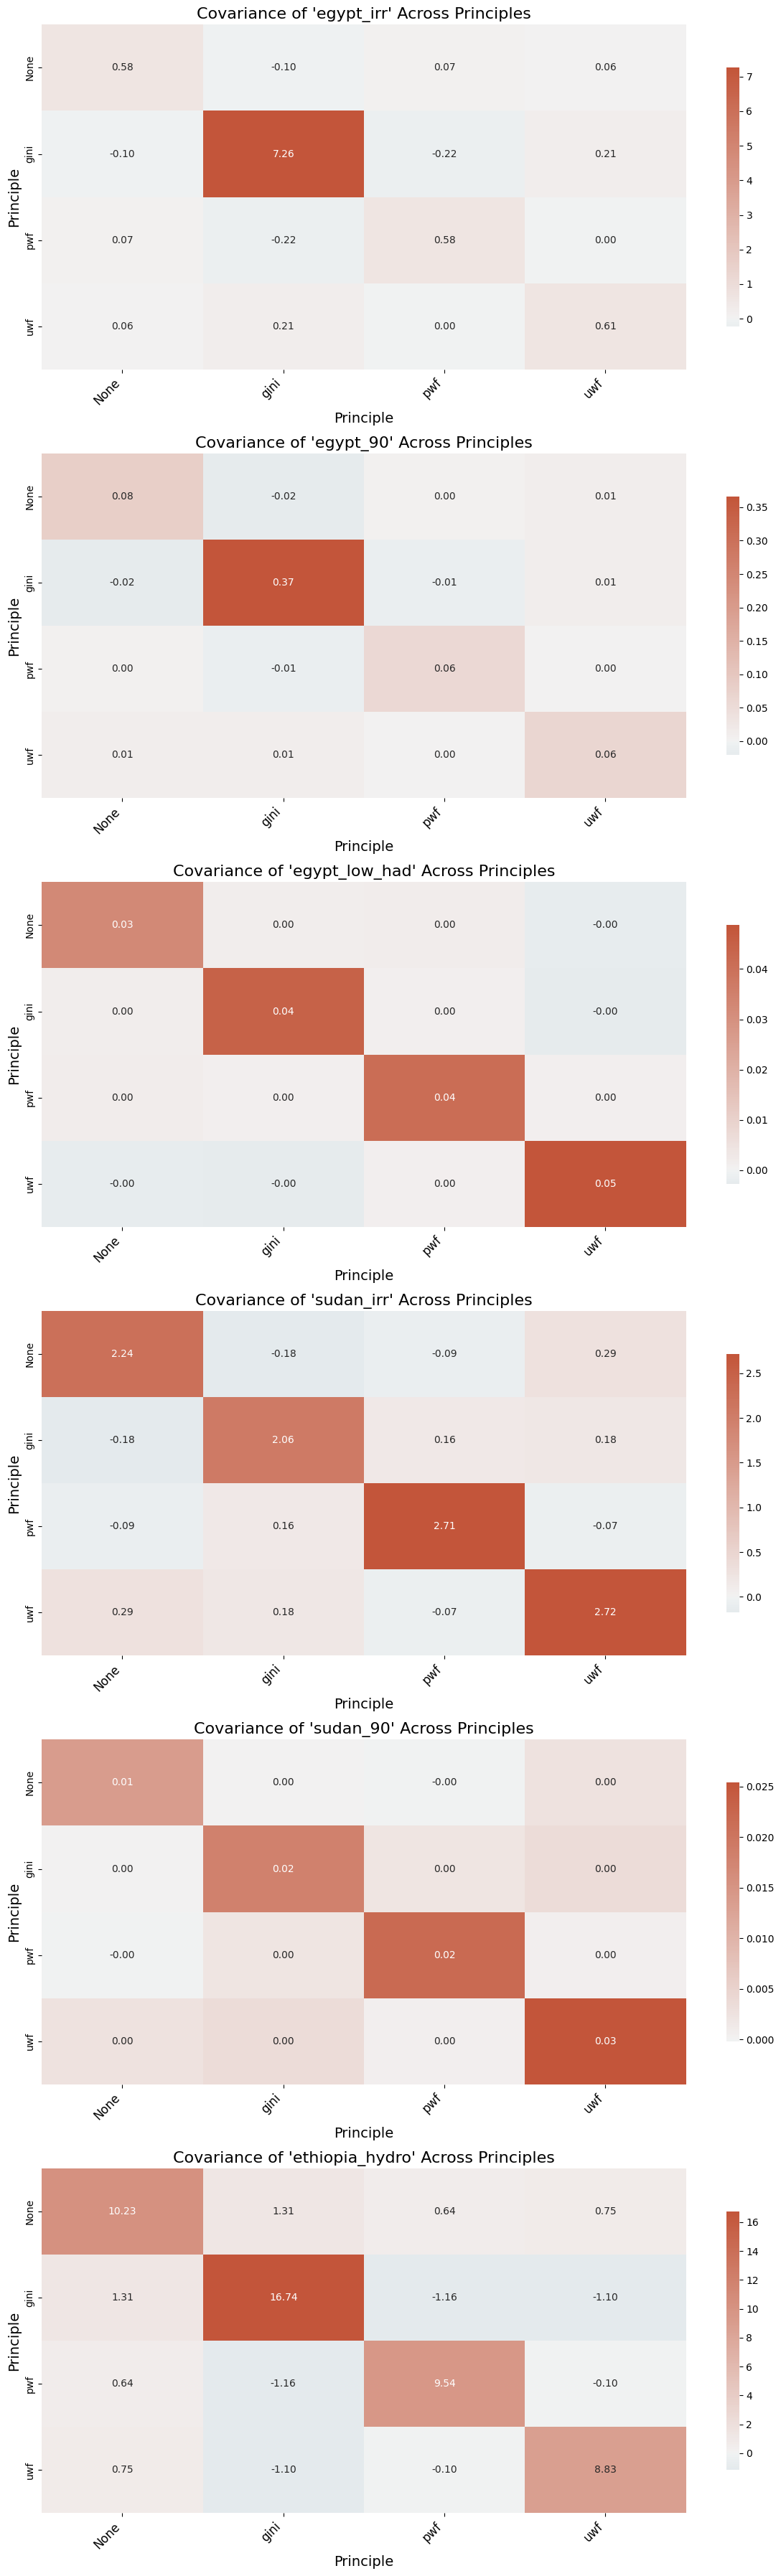

In [11]:
# Number of objectives 
num_objectives = len(covariance_matrices)

# Setup the subplots 
fig, axes = plt.subplots(nrows=num_objectives, figsize=(12, 6 * num_objectives))

# Adjust layout space
fig.subplots_adjust(hspace=0.5)

for ax, (objective_name, cov_matrix) in zip(axes, covariance_matrices.items()):
    # Use a diverging colormap for positive and negative covariance values
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    sns.heatmap(cov_matrix, annot=True, fmt=".2f", ax=ax, cmap=cmap, center=0,
                cbar_kws={"shrink": 0.75})
    
    ax.set_title(f"Covariance of '{objective_name}' Across Principles", fontsize=16)
    ax.set_xlabel('Principle', fontsize=14)
    ax.set_ylabel('Principle', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

plt.tight_layout()
plt.show()
